In [1]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import random
import math

In [2]:
# Configurar dispositivo CUDA si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [3]:
class BasuraDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, img_size=28, val_split=0.2, test_split=0.1):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.val_split = val_split
        self.test_split = test_split
        self.classes = ['CascaraManzana', 'EnvoltorioSnacks', 'Facturas', 'GuantesLatex', 'Hojas']
        
        # Transformaciones para las imágenes
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def setup(self, stage=None):
        # Cargar dataset completo
        full_dataset = datasets.ImageFolder(
            root=self.data_dir,
            transform=self.transform
        )
        
        # Dividir en train, val, test
        dataset_size = len(full_dataset)
        val_size = int(dataset_size * self.val_split)
        test_size = int(dataset_size * self.test_split)
        train_size = dataset_size - val_size - test_size
        
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size]
        )
        
        # Guardar las clases
        self.classes = full_dataset.classes

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=0)

In [4]:
class AttnBasuraDataset(Dataset):
    def __init__(self, dataset, patch_size=(7, 7)):
        self.dataset = dataset
        self.patch_size = patch_size
        self.patches_per_side = 28 // patch_size[0]  # 28/7 = 4 patches por lado
        self.num_patches = self.patches_per_side * self.patches_per_side  # 16 patches total

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        # Crear patches de 7x7
        h, w = self.patch_size
        patches = img.unfold(1, h, h).unfold(2, w, w)  # 1 x 4 x 4 x 7 x 7
        patches = patches.contiguous().view(self.num_patches, h * w)  # 16 x 49
        
        return patches, label

class BasuraTransformerDataModule(BasuraDataModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.patch_size = (7, 7)

    def setup(self, stage=None):
        super().setup(stage)
        
        # Convertir datasets a formato de patches
        self.train_dataset = AttnBasuraDataset(self.train_dataset, self.patch_size)
        self.val_dataset = AttnBasuraDataset(self.val_dataset, self.patch_size)
        self.test_dataset = AttnBasuraDataset(self.test_dataset, self.patch_size)

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = n_embd // n_heads
        
        # Asegurarse de que n_embd es divisible por n_heads
        assert n_embd % n_heads == 0, "n_embd must be divisible by n_heads"
        
        self.key = nn.Linear(n_embd, n_embd)
        self.query = nn.Linear(n_embd, n_embd)
        self.value = nn.Linear(n_embd, n_embd)
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, L, F = x.size()
        
        # Proyectar y dividir en heads
        k = self.key(x).view(B, L, self.n_heads, F // self.n_heads).transpose(1, 2)
        q = self.query(x).view(B, L, self.n_heads, F // self.n_heads).transpose(1, 2)
        v = self.value(x).view(B, L, self.n_heads, F // self.n_heads).transpose(1, 2)
        
        # Calcular atención
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        att = self.dropout(att)
        
        # Aplicar atención a los valores
        y = att @ v
        
        # Reensamblar
        y = y.transpose(1, 2).contiguous().view(B, L, F)
        return self.proj(y)

class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.1)
        )
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Atención con residual connection
        x_attn = self.attn(self.ln1(x))
        x = x + self.dropout(x_attn)
        
        # MLP con residual connection
        x_mlp = self.mlp(self.ln2(x))
        x = x + self.dropout(x_mlp)
        
        return x

class BasuraTransformer(pl.LightningModule):
    def __init__(self, n_input=49, n_embd=64, seq_len=16, n_heads=4, n_layers=3, num_classes=5):
        super().__init__()
        self.save_hyperparameters()
        
        # Embedding de posición
        self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, n_embd))
        nn.init.normal_(self.pos_emb, std=0.02)
        
        # Embedding de entrada
        self.inp_emb = nn.Linear(n_input, n_embd)
        
        # Capas Transformer
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(n_embd, n_heads) for _ in range(n_layers)
        ])
        
        # Capa de normalización final
        self.ln_final = nn.LayerNorm(n_embd)
        
        # Clasificador
        self.fc = nn.Linear(n_embd * seq_len, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, L, F = x.size()
        
        # Embedding de entrada
        x = self.inp_emb(x)  # (B, L, n_embd)
        
        # Añadir posición embedding
        x = x + self.pos_emb[:, :L, :]
        x = self.dropout(x)
        
        # Pasar por capas Transformer
        for block in self.transformer_blocks:
            x = block(x)
        
        # Normalización final
        x = self.ln_final(x)
        
        # Clasificador
        x = x.reshape(B, -1)  # Aplanar
        return self.fc(x)

    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('test_loss', loss)
        self.log('test_acc', acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return torch.argmax(y_hat, dim=1)

In [8]:
# Configurar paths
data_dir = "DataasetBasura"  # Ajusta este path según tu estructura

# Inicializar data module
dm = BasuraTransformerDataModule(
    data_dir=data_dir,
    batch_size=32,
    img_size=28,
    val_split=0.15,
    test_split=0.15
)

dm.setup()

# Ver información del dataset
print(f"Clases: {dm.classes}")
print(f"Train samples: {len(dm.train_dataset)}")
print(f"Val samples: {len(dm.val_dataset)}")
print(f"Test samples: {len(dm.test_dataset)}")

# Inicializar modelo
model = BasuraTransformer(
    n_input=49,      # 7x7 patches
    n_embd=64,       # Dimensión de embedding
    seq_len=16,      # 16 patches (4x4)
    n_heads=4,       # 4 cabezas de atención
    n_layers=3,      # 3 capas transformer
    num_classes=5    # 5 clases
)

# Mover modelo a GPU
model.to(device)

# Configurar trainer
trainer = pl.Trainer(
    max_epochs=20,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    log_every_n_steps=10,
    enable_checkpointing=True,
    deterministic=True
)

# Entrenar
trainer.fit(model, dm)

# Evaluar
trainer.test(model, dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type       | Params | Mode 
----------------------------------------------------------
0 | inp_emb            | Linear     | 3.2 K  | train
1 | transformer_blocks | ModuleList | 149 K  | train
2 | ln_final           | LayerNorm  | 128    | train
3 | fc                 | Linear     | 5.1 K  | train
4 | dropout            | Dropout    | 0      | train
  | other params       | n/a        | 1.0 K  | n/a  
----------------------------------------------------------
159 K     Trainable params
0         Non-trainable params
159 K     Total params
0.638     Total estimated model params size (MB)
50        Modules

Clases: ['CascaraManzana', 'EnvoltorioSnacks', 'Facturas', 'GuantesLatex', 'Hojas']
Train samples: 35664
Val samples: 7641
Test samples: 7641
                                                                           

f:\2-2025\IA2\Labs\Lab5\env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 1115/1115 [02:34<00:00,  7.21it/s, v_num=7, train_loss=0.0901, train_acc=1.000, val_loss=0.283, val_acc=0.909]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1115/1115 [02:34<00:00,  7.21it/s, v_num=7, train_loss=0.0901, train_acc=1.000, val_loss=0.283, val_acc=0.909]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


f:\2-2025\IA2\Labs\Lab5\env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 239/239 [00:34<00:00,  6.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9328621625900269
        test_loss           0.1887514293193817
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1887514293193817, 'test_acc': 0.9328621625900269}]

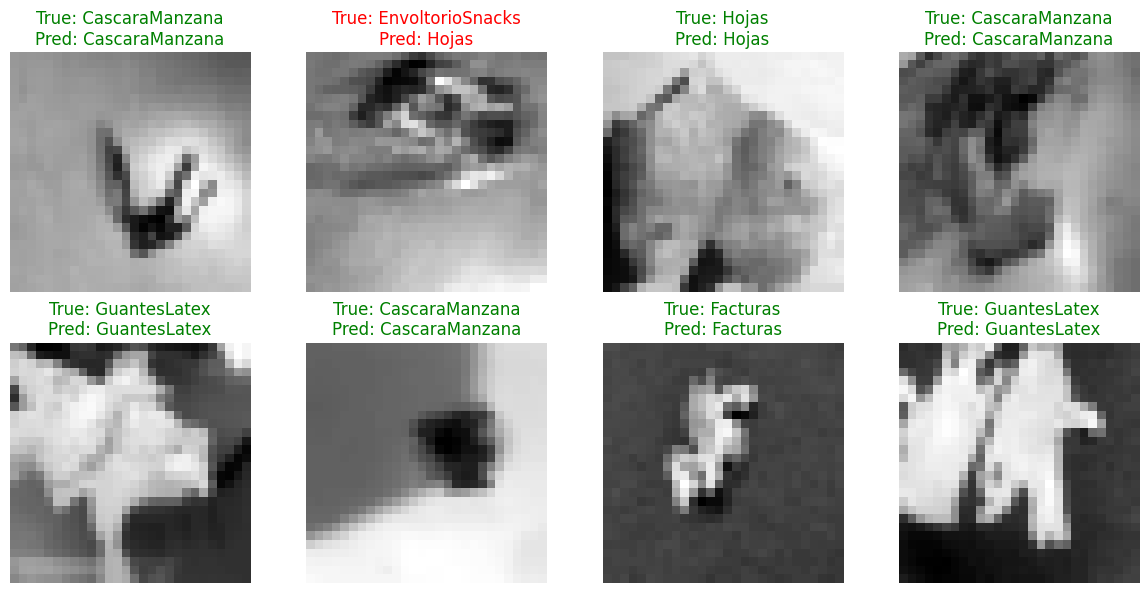

Classification Report:
                  precision    recall  f1-score   support

  CascaraManzana       0.91      0.96      0.94      1567
EnvoltorioSnacks       0.97      0.85      0.91      1528
        Facturas       0.97      0.95      0.96      1516
    GuantesLatex       0.93      0.97      0.95      1600
           Hojas       0.94      0.97      0.95      1430

        accuracy                           0.94      7641
       macro avg       0.94      0.94      0.94      7641
    weighted avg       0.94      0.94      0.94      7641



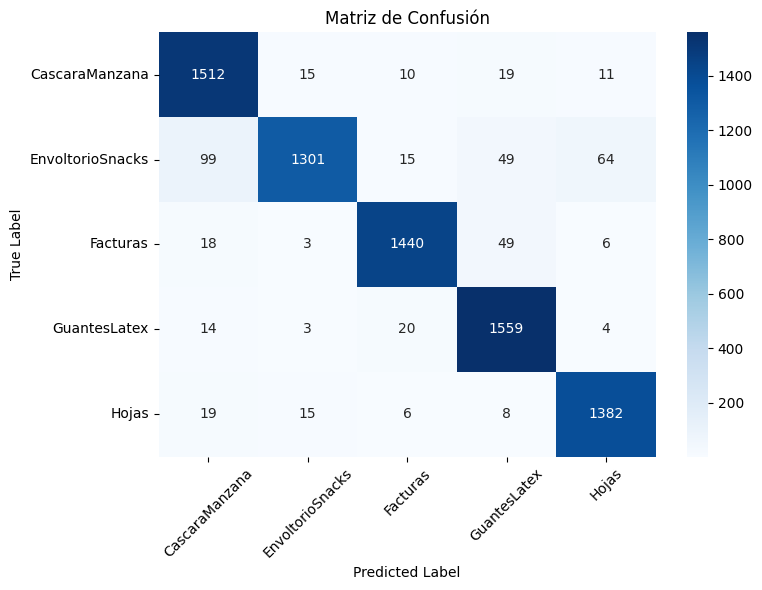

Accuracy final en validación: 0.9415


In [10]:
# Obtener batch de validación
val_loader = dm.val_dataloader()
imgs, labels = next(iter(val_loader))

# Mover datos al mismo dispositivo que el modelo
device = next(model.parameters()).device
imgs = imgs.to(device)
labels = labels.to(device)

# Predecir
model.eval()
with torch.no_grad():
    preds = model.predict(imgs)

# Mover de vuelta a CPU para visualización
imgs_cpu = imgs.cpu()
labels_cpu = labels.cpu()
preds_cpu = preds.cpu()

# Visualizar algunas muestras
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    # Reconstruir imagen desde patches
    patches = imgs_cpu[i].numpy()
    reconstructed = np.zeros((28, 28))
    
    for j in range(16):
        row = j // 4
        col = j % 4
        patch = patches[j].reshape(7, 7)
        reconstructed[row*7:(row+1)*7, col*7:(col+1)*7] = patch
    
    axes[i].imshow(reconstructed, cmap='gray')
    true_label = dm.classes[labels_cpu[i].item()]
    pred_label = dm.classes[preds_cpu[i].item()]
    color = 'green' if labels_cpu[i] == preds_cpu[i] else 'red'
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Matriz de confusión - versión corregida
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in dm.val_dataloader():
        x, y = batch
        x = x.to(device)  # Mover a GPU
        y = y.to(device)  # Mover a GPU
        pred = model.predict(x)
        all_preds.extend(pred.cpu().numpy())  # Mover a CPU para almacenar
        all_labels.extend(y.cpu().numpy())    # Mover a CPU para almacenar

# Calcular métricas
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dm.classes))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dm.classes, yticklabels=dm.classes)
plt.title('Matriz de Confusión')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Mostrar accuracy final
final_accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Accuracy final en validación: {final_accuracy:.4f}")

In [11]:
# Guardar modelo
torch.save(model.state_dict(), 'basura_transformer.pth')

# Para cargar después:
# model = BasuraTransformer(...)
# model.load_state_dict(torch.load('basura_transformer.pth'))
# model.to(device)